# CSCI 5922 (Spring 2020) Final Project
name: Timothy Mason
***
Music Genre classification using a CRNN as described in the paper blah, blah, blah...

todo: fill in citations and flesh out overview

last.fm dataset citation:

> @INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
}

> Additionally, you can mention / link to this web resource:
> 
> Last.fm dataset, the official song tags and song similarity collection for the Million Song
> Dataset, available at: http://millionsongdataset.com/lastfm

## Hyperparameters

In [1]:
min_segments = 252    # Minimum usable segment count
pickle_fn = f'./msd_subset_top50_{min_segments}.pickle'

input_shape = (None, 12, 1)
channel_axis = 3
freq_axis = 2
time_axis = 1

# Hyperparms adapted from Choi, et. al for their 3,000,000 parameter size CRNN model
CNN_dropout = 0.1
# CNN1_N = 169
# CNN1_kernel = (3,3)
# CNN1_pool = (2,2)

CNN2_N = 339
CNN2_kernel = (3,3)
CNN2_pool = (2,2)

CNN3_N = 339
CNN3_kernel = (3,3)
CNN3_pool = (2,2)

CNN4_N = 339
CNN4_kernel = (3,3)
CNN4_pool = (3,3)

RNN_dropout = 0.3
RNN1_N = 169
RNN2_N = 169

training_batch_size=10
training_epochs=50

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm      # for easy and attractive progress bars

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

## Import data functions

In [3]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories=("track_id",
                                      "artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
#                                       "analysis_sample_rate", # sample rate (Hz) for the analysis
#                                       "duration",             # length of the piece (seconds)
#                                       "tempo",                # tempo of the piece (avg beats per minute)
#                                       "beats_start",          # list of time markers (seconds) for beats
#                                       "bars_start",           # list of time markers (seconds) for bars
#                                       "tatums_start",         # "list of tatum markers, in seconds. Tatums 
#                                                               # represent the lowest regular pulse train that
#                                                               # a listener intuitively infers from the timing
#                                                               # of perceived musical events (segments)."
#                                       "segments_start",       # list of time markers (seconds) for segments
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     ), 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading                                      ubset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            d[c] = t
        h5file.close()
        
        # Only keep records with at least the minimum number of segments
        if len(d['segments_pitches']) >= min_segments:
            data.append(d)
            
    return pd.DataFrame(data)

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the tags from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame.  Index by track_id and also keep artist and title for more precise matching
    to the MSD.  Result is filtered to only return entries which have tags in the top-50.  Assumes that
    the list of last.fm top 50 tags is in the file top50_lastfm_tags.csv in the current working directory.
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset, filtered to only contain entries which
    have tags in the top 50 of last.fm tags.
    """
    
    # load the top 50 tags into a set because set intersection will be an elegant way to only keep those
    # tags which are in the top 50.
    top50 = set(pd.read_csv('top50_lastfm_tags.csv').Tag)
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            
            # change the key for the name of the artist to have consistent naming with the MSD
            j['artist_name'] = j.pop('artist') 
            
            if j['tags']:      # skip tag-less entries
                # Only keep the tags, and only if they are in the top50 set.  Do the list filtering by
                # using set intersection of the top50 set and use column slice feature of a numpy array to
                # extract just the tag names.  (The JSON file has both the tag name and an integer number
                # for each tag - I don't need that integer number)
                t = list(top50.intersection(np.array(j['tags'])[:,0]))
                if t:
                    j['top50_tags'] = t
                    data.append(j)
    
    return pd.DataFrame(data)[['track_id','artist_name','title','top50_tags']] # only keep the useful bits


## Load and merge the datasets

Loading the MSD subset from the h5 file tree takes several minutes.  Save time on reruns by saving a snapshot
of a fully loaded and filtered dataset to a Python pickle file.

In [4]:
import os.path

if os.path.isfile(pickle_fn):
    # This dataset has already been generated.  Load the snapshot
    df = pd.read_pickle(pickle_fn)
else:
    # A snapshot is not available for this dataset.  Load it then save the snapshot
    df = hdf_tree_to_dataframe().merge( right=json_tree_to_dataframe(), on=('track_id','title','artist_name') )
    df.to_pickle(pickle_fn)
    print(f"Created snapshot file {pickle_fn}")


### Inspect the final dataset

In [5]:
# I'm sure there's a more 'Pythonic' way to do this, but this works in a pinch
seg_max=0
for i in df.index:
    segs,_ = df.segments_pitches[i].shape
    if segs>seg_max:
        seg_max = segs

df

,track_id,artist_name,release,title,year,segments_pitches,segments_timbre,top50_tags
0,TRARRER128F9328521,Brand X,X Communication : Trilogy II,Liquid Time (composition by John Goodsall),0,"[[0.253, 0.295, 0.256, 0.255, 0.365, 0.256, 0....","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[chill]
1,TRARREF128F422FD96,Dead Kennedys,Milking The Sacred Cow,Halloween,1982,"[[0.146, 0.203, 0.219, 0.209, 0.172, 0.123, 0....","[[23.928, -119.362, 33.96, -122.038, 8.715, 18...","[indie, 80s, punk, american, rock, party, alte..."
2,TRARUOP12903CF2384,Shadows Fall,The War Within,What Drives The Weak,2004,"[[0.937, 0.557, 0.215, 0.198, 0.112, 0.135, 0....","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[metal, hard rock, cool, seen live, 00s, favor..."
3,TRARUHU128F92FDC00,Spoonie Gee,The Sugar Hill Records Story,Spoonie Is Back,0,"[[1.0, 0.284, 0.224, 0.217, 0.245, 0.285, 0.38...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[80s]
4,TRARIRG128F147FC96,Phil Collins,Face Value,I'm Not Moving,1981,"[[0.819, 0.683, 0.6, 0.67, 0.291, 0.274, 0.689...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[classic rock, 80s, pop, singer-songwriter, ea..."
...,...,...,...,...,...,...,...,...
2357,TRBBYOI128F4256732,Black Flag,I Can See You,Out Of This World,1985,"[[0.345, 0.254, 0.161, 0.162, 0.25, 0.542, 0.3...","[[0.102, 168.868, 6.486, -31.413, 55.144, -50....","[punk, hard rock, soul]"
2358,TRBBYDT128F14805B4,Phil Collins,Serious Hits... Live!,You Can't Hurry Love (Live),1990,"[[0.521, 0.515, 0.559, 0.631, 0.818, 0.722, 0....","[[33.671, 84.55, 202.282, 2.574, 46.344, 64.34...","[80s, pop, rock]"
2359,TRBBYFJ128F42A22D4,Jim Reeves,Christmas Songbook,Jingle Bells,1963,"[[1.0, 0.923, 0.508, 0.49, 0.511, 0.522, 0.548...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[folk, easy listening, country, male vocalists]"
2360,TRBBPGL128F933E34C,Joe Bataan,Call My Name,Ernestine,2005,"[[0.568, 1.0, 0.704, 0.628, 0.761, 0.782, 0.60...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[chill, soul]"


### Sample Data Visualization

Because it looks cool!

### Only When I'm Drunk

Artist: *Tha Alkaholiks*

Release:*21 & Over*

released 1993

Tags: ['Hip-Hop', '90s']

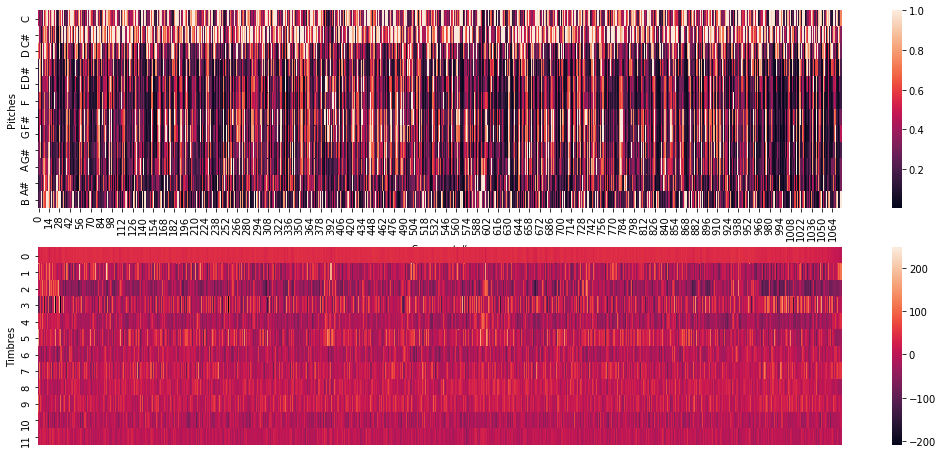

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'### {df.title[i]}\n\nArtist: *{df.artist_name[i]}*\n\nRelease:*{df.release[i]}*'
    if df.year[i] != 0:
        name += f'\n\nreleased {df.year[i]}'
    name += '\n\n'
    name += f'Tags: {df.top50_tags[i]}'
    display(Markdown(name))
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(18,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

# Build The CRNN

In [7]:
try:
  # %tensorflow_version magic only exists (and only needed) in Colab.  I control the tensorflow version
  # on my local machine by virtue of which package I install in the anaconda v-env
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import layers
#
# model adapted from music_tagger_crnn.py at https://github.com/keunwoochoi/music-auto_tagging-keras
#

model = tf.keras.Sequential()

# Input block
model.add(layers.Input(shape=input_shape))
# model.add(layers.ZeroPadding2D(padding=(0, 37)))
model.add(layers.BatchNormalization(axis=freq_axis, name='bn_0_freq'))

# First Convolutional Block
#   Choi et. al, used 4 CNN blocks, but the data set I'm using is too narrow (12 as opposed to 96) to 
#   support 4 blocks, so I'm omitting the first block.
# model.add(layers.Conv2D(filters=CNN1_N, kernel_size=CNN1_kernel, padding='same', name='conv1'))
# model.add(layers.BatchNormalization(axis=channel_axis, name='bn1'))
# model.add(layers.ELU())
# model.add(layers.MaxPool2D(pool_size=CNN1_pool, strides=CNN1_pool, name='pool1'))
# model.add(layers.Dropout(rate=CNN_dropout, name='dropout1'))

# Second Convolutional Block
model.add(layers.Conv2D(filters=CNN2_N, kernel_size=CNN2_kernel, padding='same', name='conv2'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN2_pool, strides=CNN2_pool, name='pool2'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout2'))

# Third Convolutional Block
model.add(layers.Conv2D(filters=CNN3_N, kernel_size=CNN3_kernel, padding='same', name='conv3'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN3_pool, strides=CNN3_pool, name='pool3'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout3'))

# Fourth convolutional Block
model.add(layers.Conv2D(filters=CNN4_N, kernel_size=CNN4_kernel, padding='same', name='conv4'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN4_pool, strides=CNN4_pool, name='pool4'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout4'))

# reshaping - "Integer truncate UP trick" thanks David Bau, answer #102 at 
# https://stackoverflow.com/questions/2356501/how-do-you-round-up-a-number-in-python
longest_RNN = -(seg_max // -CNN2_pool[1])
longest_RNN = -(longest_RNN // -CNN3_pool[1])
longest_RNN = -(longest_RNN // -CNN4_pool[1])
model.add(layers.Reshape(target_shape=(longest_RNN, CNN4_N)))

# RNN (GRU) blocks
model.add(layers.GRU(units=RNN1_N, return_sequences=True, name='gru1'))
model.add(layers.GRU(units=RNN2_N, return_sequences=False, name='gru2'))
model.add(layers.Dropout(rate=RNN_dropout))

# Output
model.add(layers.Dense(units=50, activation='sigmoid', name='output'))


## Compile The Model

In [8]:
#
# Compile the model
#
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.AUC()])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_0_freq (BatchNormalizatio (None, None, 12, 1)       48        
_________________________________________________________________
conv2 (Conv2D)               (None, None, 12, 339)     3390      
_________________________________________________________________
bn2 (BatchNormalization)     (None, None, 12, 339)     1356      
_________________________________________________________________
elu (ELU)                    (None, None, 12, 339)     0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, None, 6, 339)      0         
_________________________________________________________________
dropout2 (Dropout)           (None, None, 6, 339)      0         
_________________________________________________________________
conv3 (Conv2D)               (None, None, 6, 339)      1

## Set up Training Data

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Deconstruct the segments_pitches arrays so they can be reconstructed as a ragged tensor.  Using list of
# fixed-size tensors as outlined for 'Uniform Inner Dimensions' in RaggedTensor documentation: 
# https://www.tensorflow.org/guide/ragged_tensor#uniform_inner_dimensions
XT = []
lengths = []
for y in tqdm(df.segments_pitches.values, "Unrolling pitches for RaggedTensor construction"):
    d,_ = y.shape
    lengths.append(d)
    for x in y:
        XT.append(tf.convert_to_tensor(x.reshape((x.shape[0],1))))
X = tf.RaggedTensor.from_row_lengths(values=XT, row_lengths=lengths)

# Allow interim lists to be garbage collected:
XT = lengths = None

# Use an sklearn convenience utility to create a one-hot encoding of the truth values
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df.top50_tags)
encoded_classes = tuple(mlb.classes_)

print("Ragged Tensor of pitch data:")
print(f"  Shape = {X.shape}")
print(f"  Number of ragged dimensions: {X.ragged_rank}")
print()


Unrolling pitches for RaggedTensor construction: 100%|██████████| 2362/2362 [00:24<00:00, 97.29it/s] 


Ragged Tensor of pitch data:
  Shape = (2362, None, 12, 1)
  Number of ragged dimensions: 1



## Fit the Model

In [ ]:
model.fit(X, Y,
          batch_size=training_batch_size,
          epochs=training_epochs,
          verbose=1,
#           use_multiprocessing=True,
          validation_split=0.05)

model.summary()